# Visualisations demandées dans le PDF (section 5)
- Ventes par mois + comparaison année précédente
- Ventes des 5 premières villes
- Comparaison des bénéfices par canal
- Top 5 clients + comparaison avec N-1
- Last 5 clients + comparaison avec N-1
- Cartes pour ventes, bénéfices, marges, produits (optionnelle)

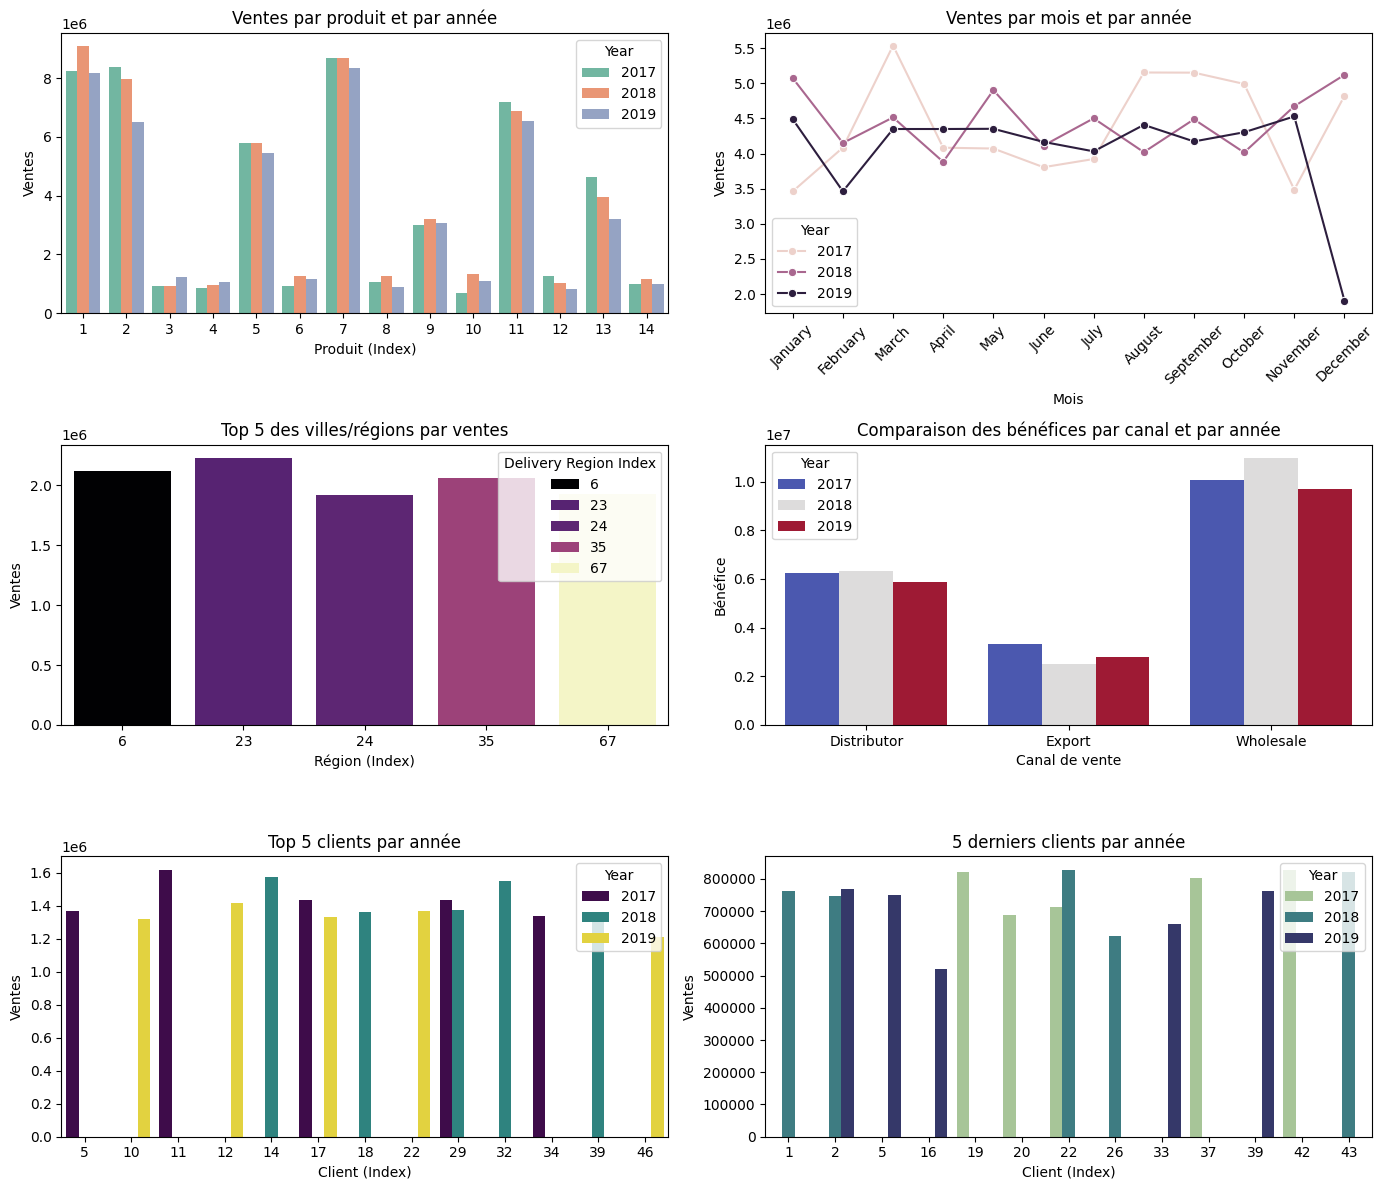

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import calendar

# Charger le fichier Excel
df = pd.read_excel("sales.xlsx")

# Créer les colonnes calculées
df["Sales"] = df["Order Quantity"] * df["Unit Selling Price"]
df["Cost"] = df["Order Quantity"] * df["Unit Cost"]
df["Profit"] = df["Sales"] - df["Cost"]

# Créer une table de dates à partir de OrderDate
date_range = pd.date_range(start=df["OrderDate"].min(), end=df["OrderDate"].max(), freq='D')
date_table = pd.DataFrame({"Date": date_range})

date_table["Year"] = date_table["Date"].dt.year
date_table["Month"] = date_table["Date"].dt.month
date_table["Month Name"] = date_table["Date"].dt.strftime('%B')
date_table["Quarter"] = date_table["Date"].dt.quarter
date_table["Day"] = date_table["Date"].dt.day
date_table["Day Name"] = date_table["Date"].dt.strftime('%A')
date_table["Week"] = date_table["Date"].dt.isocalendar().week

# Renommer pour correspondre à la colonne OrderDate
date_table_renamed = date_table.rename(columns={"Date": "OrderDate"})
# Fusion
df_merged = pd.merge(df, date_table_renamed, on="OrderDate", how="left")

# Regrouper les ventes par produit et année
product_sales = df_merged.groupby(["Product Description Index", "Year"]).agg({
    "Sales": "sum"
}).reset_index()

# Regrouper les ventes par mois
monthly_sales = df_merged.groupby(["Year", "Month Name"]).agg({
    "Sales": "sum"
}).reset_index()

# Trier les mois dans l'ordre correct
monthly_sales["Month Number"] = monthly_sales["Month Name"].apply(lambda x: list(calendar.month_name).index(x))
monthly_sales = monthly_sales.sort_values(by=["Month Number", "Year"])

# Regrouper les ventes par région
region_sales = df.groupby("Delivery Region Index").agg({
    "Sales": "sum"
}).sort_values(by="Sales", ascending=False).head(5).reset_index()

# Recalculer les bénéfices par canal et par année
channel_profit = df_merged.groupby(["Channel", "Year"]).agg({
    "Profit": "sum"
}).reset_index()

# Reprendre les ventes par client et année
client_sales = df_merged.groupby(["Customer Name Index", "Year"]).agg({
    "Sales": "sum"
}).reset_index()

# Sélectionner les Top 5 clients de chaque année sans apply
top5_clients = (
    client_sales
    .sort_values(['Year', 'Sales'], ascending=[True, False])
    .groupby('Year')
    .head(5)
    .reset_index(drop=True)
)

# Sélectionner les 5 derniers clients de chaque année sans apply
last5_clients = (
    client_sales
    .sort_values(['Year', 'Sales'], ascending=[True, True])
    .groupby('Year')
    .head(5)
    .reset_index(drop=True)
)

# Visualisation avec deux graphiques par ligne
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))  # 3 lignes, 2 colonnes

# Premier graphique : Ventes par produit et par année
sns.barplot(data=product_sales, x="Product Description Index", y="Sales", hue="Year", palette="Set2", ax=axes[0, 0])
axes[0, 0].set_title("Ventes par produit et par année")
axes[0, 0].set_xlabel("Produit (Index)")
axes[0, 0].set_ylabel("Ventes")

# Deuxième graphique : Ventes par mois et par année
sns.lineplot(data=monthly_sales, x="Month Name", y="Sales", hue="Year", marker="o", ax=axes[0, 1])
axes[0, 1].set_title("Ventes par mois et par année")
axes[0, 1].set_xlabel("Mois")
axes[0, 1].set_ylabel("Ventes")
axes[0, 1].tick_params(axis='x', rotation=45)

# Troisième graphique : Top 5 des régions par ventes
sns.barplot(data=region_sales, x="Delivery Region Index", y="Sales", hue="Delivery Region Index", palette="magma", ax=axes[1, 0])
axes[1, 0].set_title("Top 5 des villes/régions par ventes")
axes[1, 0].set_xlabel("Région (Index)")
axes[1, 0].set_ylabel("Ventes")

# Quatrième graphique : Bénéfices par canal et par année
sns.barplot(data=channel_profit, x="Channel", y="Profit", hue="Year", palette="coolwarm", ax=axes[1, 1])
axes[1, 1].set_title("Comparaison des bénéfices par canal et par année")
axes[1, 1].set_xlabel("Canal de vente")
axes[1, 1].set_ylabel("Bénéfice")

# Cinquième graphique : Top 5 clients par année
sns.barplot(data=top5_clients, x="Customer Name Index", y="Sales", hue="Year", palette="viridis", ax=axes[2, 0])
axes[2, 0].set_title("Top 5 clients par année")
axes[2, 0].set_xlabel("Client (Index)")
axes[2, 0].set_ylabel("Ventes")

# Sixième graphique : 5 derniers clients par année
sns.barplot(data=last5_clients, x="Customer Name Index", y="Sales", hue="Year", palette="crest", ax=axes[2, 1])
axes[2, 1].set_title("5 derniers clients par année")
axes[2, 1].set_xlabel("Client (Index)")
axes[2, 1].set_ylabel("Ventes")

# Ajuster la disposition et afficher
plt.tight_layout()
plt.show()